# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Change current working directory to project folder (1 mark)

In [24]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
os.chdir('D:/GreatLakes/Face Detection') # Set the working directory

### Load the "images.npy" file (4 marks)
- This file contains images with details of bounding boxes

In [25]:
import numpy as np
data = np.load('images.npy')

### Check one sample from the loaded "images.npy" file  (4 marks)

In [26]:
X=data[1,0]
X.shape
print(data.shape,X.shape)

(409, 2) (697, 1280, 4)


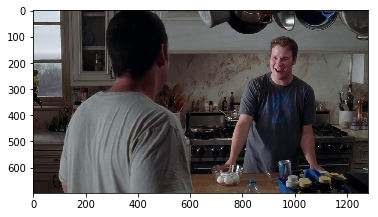

In [27]:
from matplotlib import pyplot as plt
plt.imshow(X)
plt.show()
from PIL import Image
im = Image.fromarray(data[0,0].astype(np.uint8))
im.show()

In [28]:
data[3]

array([array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[ 80,  31,  18, 255],
        [ 82,  36,  23, 255],
        [ 79,  31,  21, 255],
        ...,
        [121, 114, 104, 255],
        [120, 112, 104, 255],
        [116, 109,  99, 255]],

       [[ 73,  38,  20, 255],
        [ 76,  40,  24, 255],
        [ 79,  45,  30, 255],
        ...,
        [121, 112, 104, 255],
        [117, 110, 102, 255],
        [113, 106,  97, 255]],

     

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [29]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [30]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [31]:
X_train.shape

(409, 224, 224, 3)

In [32]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-0.34901959 -0.75686276 -0.83529413]
  [-0.35686272 -0.7647059  -0.84313726]
  [-0.36470586 -0.74901962 -0.8509804 ]
  ...
  [-0.81960785 -0.88235295 -0.96078432]
  [-0.11372548 -0.08235294 -0.16862744]
  [-0.01960784 -0.06666666 -0.13725489]]

 [

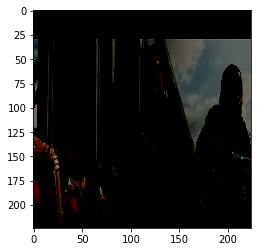

In [33]:
from matplotlib import pyplot
n = 3
print(X_train[n])
pyplot.imshow(X_train[n])

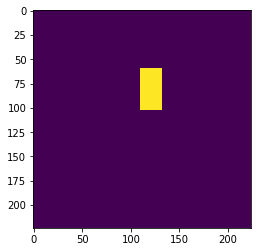

In [34]:
pyplot.imshow(masks[n]) # showing the mask for the image

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [35]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1, weights="imagenet")

    block0 = model.get_layer("conv_pw_1_relu").output 
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [36]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(trainable=False)

# Print summary
model.summary()

17227776/17225924 [==============================] - 89s 5us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [37]:
from keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    dice = (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
    return dice

### Define loss

In [38]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [39]:
model.compile(optimizer='adam', loss=loss, metrics= [(dice_coefficient)])

### Define checkpoint and earlystopping

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.3, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [41]:
model.fit(X_train,masks,          
          epochs=10,
          batch_size=1,callbacks=[checkpoint, stop, reduce_lr])

Epoch 1/10
408/409 [============================>.] - ETA: 0s - loss: 1.0818 - dice_coefficient: 0.6864
Epoch 00001: loss improved from inf to 1.08139, saving model to model-1.08.h5
409/409 [==============================] - 367s 898ms/sample - loss: 1.0814 - dice_coefficient: 0.6863
Epoch 2/10
408/409 [============================>.] - ETA: 1s - loss: 0.7238 - dice_coefficient: 0.7557
Epoch 00002: loss improved from 1.08139 to 0.72412, saving model to model-0.72.h5
409/409 [==============================] - 605s 1s/sample - loss: 0.7241 - dice_coefficient: 0.7555
Epoch 3/10
408/409 [============================>.] - ETA: 1s - loss: 0.6107 - dice_coefficient: 0.7838
Epoch 00003: loss improved from 0.72412 to 0.61042, saving model to model-0.61.h5
409/409 [==============================] - 606s 1s/sample - loss: 0.6104 - dice_coefficient: 0.7839
Epoch 4/10
408/409 [============================>.] - ETA: 1s - loss: 0.5640 - dice_coefficient: 0.7993
Epoch 00004: loss improved from 0.61042

Perhaps with more epochs, the model would improve

### Get the predicted mask for a sample image   (5 marks)

In [42]:
idx = 10
x=np.array(X_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)

1/1 [==============================] - 1s 903ms/sample


In [43]:
print(predict.shape, predict.min(), predict.max(), predict.mean())

(1, 224, 224) 0.0 0.9998557 0.14965688


In [44]:
predict[0]

array([[0.0000000e+00, 0.0000000e+00, 2.9802322e-08, ..., 6.7055225e-06,
        7.8976154e-06, 7.8976154e-06],
       [0.0000000e+00, 0.0000000e+00, 2.9802322e-08, ..., 6.7055225e-06,
        7.8976154e-06, 7.8976154e-06],
       [2.9802322e-08, 2.9802322e-08, 0.0000000e+00, ..., 1.3411045e-05,
        5.8412552e-06, 5.8412552e-06],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.9604645e-08,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

### Impose the mask on the image (5 marks)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


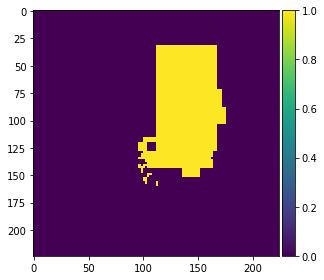

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


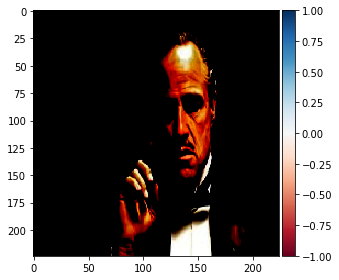

In [45]:
from skimage.io import imread, imshow


predict = (predict > 0.5).astype(np.uint8)
imshow(np.squeeze(predict[0]))
plt.show()
 
imshow(X_train[idx])
 
plt.show()

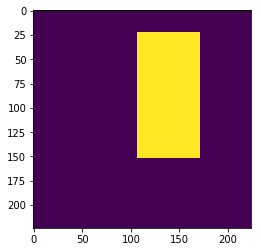

In [46]:
pyplot.imshow(masks[10]) # Original Mask for comparison

Overall quite accurate prediction for this image